# 数据准备

In [1]:
import os  
import torch  
import pandas as pd  
import matplotlib.pyplot as plt
  
    #step1:加载数据集
# 设置数据集的路径  
data_dir = '../../../DataFiles/ODS/strain'   
# 创建空的列表来存储所有的DataFrame  
X_data0 = []  
y_data0 = []
# 遍历指定目录下的所有文件  
for filename in os.listdir(data_dir):  
    if filename.endswith('.csv'):  
        # 构建文件的完整路径  
        file_path = os.path.join(data_dir, filename)  
        # 读取Excel文件  
        df = pd.read_csv(file_path)
        serie=df.iloc[:, 0]
        version_without_extension = filename.rsplit(".", 1)[0] 
        serie.name=version_without_extension
        # 将读取的DataFrame添加到列表中  
        X_data0.append(serie)
        y_data0.append(version_without_extension)

    #step2:遍历X_data0中的每个DataFrame，并删除非数字数据  
cleaned_data = []  
for df in X_data0:  
    df_cleaned = df[pd.to_numeric(df, errors='coerce').notnull()]  
    cleaned_data.append(df_cleaned)  
 

    #step3:将X_data0中的每个DataFrame的所有元素变为float类型 
for i, df in enumerate(cleaned_data):  
    X_data0[i] = df.astype(float) 

# 初始化X_data1来存储结果  
X_data1 = []  
  
# 遍历X_data0中的每个Series  
for series in X_data0:  
    # 计算步长（由于重叠率为50%，步长为序列长度的一半）  
    step_size = 1024  # 因为2048的一半是1024，且我们想要50%的重叠  
    # 初始化一个空的list来存储子序列  
    subsequences = []  
    # 使用range和步长来生成子序列  
    for i in range(0, len(series) - 2048+ 1, step_size):  
        # 确保切片是一维的，并转换为Series（虽然这里切片已经是Series）  
        subsequence = series.iloc[i:i+2048]  
        subsequences.append(subsequence) 
    X_data1.append(subsequences)  
print((type(X_data1),len(X_data1),len(X_data1[0])))

import pandas as pd  
import numpy as np  
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import LabelEncoder  
from keras.utils import to_categorical
import time  
from keras.callbacks import Callback  
import torch 

# 假设 X_data1 已经定义好了  
all_data = []  
all_labels = []  
  
for sublist in X_data1:  
    for series in sublist:  
        # 假设每个series是pandas Series  
        all_data.append(series.values)  
        all_labels.append(series.name)  
  
# 将数据转换为numpy数组  
data_array = np.array(all_data)  
# 将标签转换为编码  

label_encoder = LabelEncoder()  
labels_encoded = label_encoder.fit_transform(all_labels)  
  
# 如果需要one-hot编码  
labels_one_hot = to_categorical(labels_encoded)  
  
# 这里你可能需要reshape data_array 以符合LSTM的输入要求  
# LSTM通常要求输入形状为 (samples, time_steps, features)  
# 假设每个series的长度相同，或者你可以填充/截断它们以具有相同的长度  
# time_steps = data_array.shape[1]  # 假设所有series长度相同  
# data_array = data_array.reshape(-1, time_steps, 1)  # 增加一个维度以匹配LSTM的输入要求

# 分割数据集  
X_train, X_temp, y_train, y_temp = train_test_split(data_array, labels_one_hot, test_size=0.3, random_state=42)  
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print((type(X_train),X_train.shape,type(y_train),y_train.shape))
X_train_first_12 = X_train[:12]  

(<class 'list'>, 2, 1814)
(<class 'numpy.ndarray'>, (2412, 2048), <class 'numpy.ndarray'>, (2412, 2))


# LMD的实现和效果展示
- 我的个人理解：[LMD](./LMD.md)；

## step1:设置LMD的函数

In [3]:
from PyLMD import LMD
import PyLMD

lmd = LMD()

## step2:对原始信号进行LMD操作，获得IMF组；

In [4]:
import numpy as np
from PyEMD import CEEMDAN
# 假设你已经有一个信号
signal = X_train_first_12[0]  # 将长度为2048的信号替换为你的信号


# 使用LMD对信号进行分解
IMFs,residual =lmd.lmd(signal)


# # 计算残差
# residual = signal - np.sum(IMFs, axis=0)

# 信号重构
reconstructed_signal = np.sum(IMFs, axis=0)+ residual

print("IMFs shape:", IMFs.shape)
print("Residual shape:", residual.shape)
print("Reconstructed signal shape:", reconstructed_signal.shape)


IMFs shape: (7, 2048)
Residual shape: (2048,)
Reconstructed signal shape: (2048,)


## step3:显示IMF组和原始信号和重构信号；
- 每个IMF都代表了原始信号的某种固有振动模式信息；
- IMF包含的信息可通过[筛选](../../ModelsContrast/110spmemdlstmvibration.ipynb)后，以达到去噪的效果；之后再重构；

C:\Users\chell\anaconda3\envs\110SPMEnv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chell\anaconda3\envs\110SPMEnv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chell\anaconda3\envs\110SPMEnv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20449 (\N{CJK UNIFIED IDEOGRAPH-4FE1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chell\anaconda3\envs\110SPMEnv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21495 (\N{CJK UNIFIED IDEOGRAPH-53F7}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


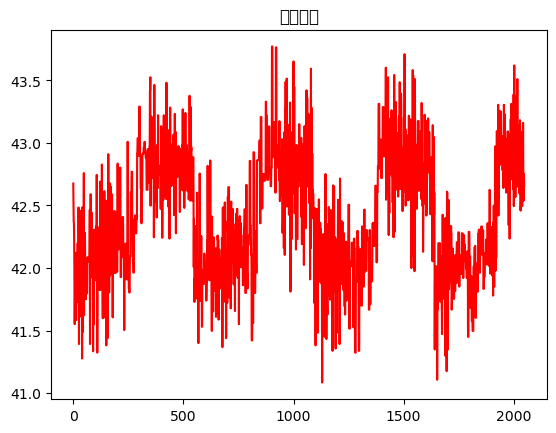

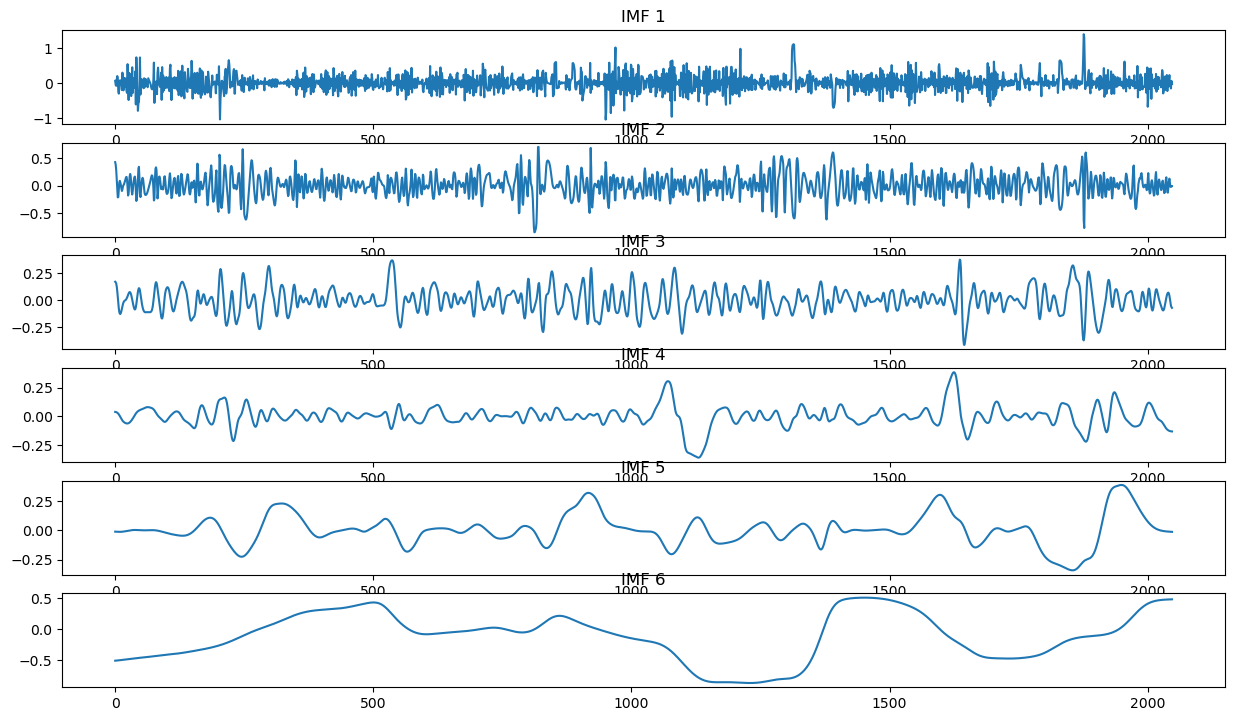

C:\Users\chell\anaconda3\envs\110SPMEnv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chell\anaconda3\envs\110SPMEnv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26500 (\N{CJK UNIFIED IDEOGRAPH-6784}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


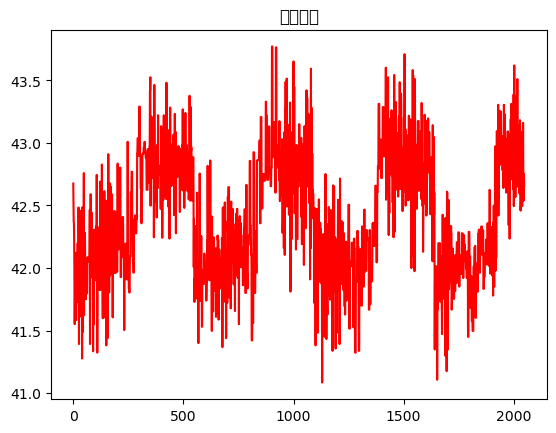

C:\Users\chell\anaconda3\envs\110SPMEnv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 27531 (\N{CJK UNIFIED IDEOGRAPH-6B8B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chell\anaconda3\envs\110SPMEnv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


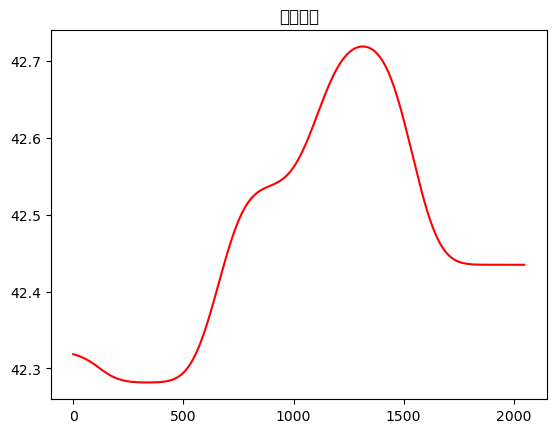

In [5]:
plt.plot(signal, 'r')
plt.title("原始信号")
plt.show()

plt.figure(figsize=(15,10))
for num in range(6):
    plt.subplot(6+1, 1, num+2)
    plt.plot(IMFs[num])
    plt.title("IMF "+str(num+1))
plt.show()

plt.plot(reconstructed_signal, 'r')
plt.title("重构信号")
plt.show()

plt.plot(residual, 'r')
plt.title("残差信号")
plt.show()
